Assignment
For module 2 we’ll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we’ll never need to bin large data for visualization ever again.). To demonstrate these concepts we’ll be looking at the PLUTO dataset put out by New York City’s Department of City Planning. PLUTO contains data about every tax lot in New York City. PLUTO data can be downloaded from here. Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it’ll come in handy for this assignment.

In [10]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

#from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

In [13]:
#Data Import
bk = pd.read_csv('C:/Users/hangr/Documents/Spring2019/Visualization/HW2/BK2017V11.csv', low_memory=False)
bx = pd.read_csv('C:/Users/hangr/Documents/Spring2019/Visualization/HW2/BX2017V11.csv', low_memory=False)
mn = pd.read_csv('C:/Users/hangr/Documents/Spring2019/Visualization/HW2/MN2017V11.csv', low_memory=False)
qn = pd.read_csv('C:/Users/hangr/Documents/Spring2019/Visualization/HW2/QN2017V11.csv', low_memory=False)
si = pd.read_csv('C:/Users/hangr/Documents/Spring2019/Visualization/HW2/SI2017V11.csv', low_memory=False)
ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True,sort=True)
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]

In [29]:
print(ny.head())

    APPBBL APPDate              Address  AreaSource  AssessLand  AssessTot  \
1      0.0     NaN        10 JAY STREET           2      834300   10156950   
17     0.0     NaN    1 PLYMOUTH STREET           2      129600     351000   
20     0.0     NaN   65 PLYMOUTH STREET           2      178200     236700   
22     0.0     NaN  135 PLYMOUTH STREET           2      514350    7785450   
23     0.0     NaN        20 JAY STREET           2      972000   40980600   

           BBL  BldgArea BldgClass  BldgDepth    ...      YearBuilt  ZMCode  \
1   3000010050    163894        O6      195.0    ...           1920     NaN   
17  3000070021      9585        G1      113.0    ...           1988     NaN   
20  3000160005      5000        Q0      165.0    ...           1920     NaN   
22  3000180001    211386        D5       48.0    ...           1900     NaN   
23  3000190001    500000        O6      207.0    ...           1911     NaN   

    ZipCode ZoneDist1  ZoneDist2  ZoneDist3  ZoneDist4  

Data Preparation
I’ll also do some prep for the geographic component of this data, which we’ll be relying on for datashader. You’re not required to know how I’m retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [14]:
#Data Preparation

wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc \
            +lat_1=40.66666666666666 \
            +lat_2=41.03333333333333 \
            +lat_0=40.16666666666666 \
            +lon_0=-74 \
            +x_0=300000 \
            +y_0=0 \
            +ellps=GRS80 \
            +datum=NAD83 \
            +to_meter=0.3048006096012192 \
            +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)
ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]
#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

Part 1: Binning and Aggregation  
Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and 2D histograms (also check out their close relatives: 2D density plots and the more general form: heatmaps. While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [15]:
#Binning And Aggregation
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)
layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)
fig = go.Figure(data = [trace], layout = layout)
# py.iplot(fig, filename = 'ny-year-built')          # requires plotly license
py.iplot(fig)


Question  
After a few building collapses, the City of New York is going to begin investigating older buildings for safety.
The city is particularly worried about buildings that were unusually tall when they were built, since best-practices 
for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were 
built in each year (note: you may want to use a log scale for the number of buildings). 
Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [22]:
#Select YearBuilt, NumFllors, BBL
ny_year = ny[['YearBuilt', 'NumFloors', 'BBL']].copy()
print(ny_year.iloc[0])

YearBuilt    1.920000e+03
NumFloors    1.000000e+01
BBL          3.000010e+09
Name: 1, dtype: float64


In [24]:
#Divided by decade
ny_year['YearBuilt'] = (np.ceil(ny_year['YearBuilt'] / 10.0).astype(int) * 10)



In [25]:
#Graph number of builds of a certain number of floors were built in each year
trace = go.Bar(
    x = ny_year.groupby('YearBuilt').count()['BBL'].index,
    y = ny_year.groupby('YearBuilt').count()['BBL']
)
layout = go.Layout(
    xaxis = dict(title = 'Decade Built'),
    yaxis = dict(title = 'Number of Lots Built')
)
fig = go.Figure(data = [trace], layout = layout)
py.iplot(fig) 

Binned the height by year


In [38]:
#Create a new dataframe
ny_bin= ny_year.copy()

#Round Number of floors
flrs = ((np.ceil(ny_bin['NumFloors']) - 1) // 10 * 10 + 1).astype(int)

#format bin of floors
ny_bin['Binned'] = ['{0:03d} to {1:03d} Floors'.format(x, x+9) for x in flrs]

#Create a subset of YearBuilt, Bin, NumFloors
sub_grp = ny_bin.groupby(['YearBuilt', 'Binned', 'NumFloors'])

#Create an empty dataframe
ny_flrs = pd.DataFrame()

#Add the number of floors in that dataset
ny_flrs['Number'] = sub_grp['NumFloors'].count()

#Display the year built in and bin of floor
display_yeaB_flr = ny_flrs.groupby(['YearBuilt','Binned']).sum()['Number'].unstack(level=-1, fill_value=0)

display_yeaB_flr

Binned     001 to 010 Floors  011 to 020 Floors  021 to 030 Floors  \
YearBuilt                                                            
1860                     123                  1                  0   
1870                     107                  1                  0   
1880                     237                  0                  0   
1890                     609                  3                  0   
1900                   34534                 80                  7   
1910                   82617                359                 14   
1920                  111394                496                 36   
1930                  165430                961                126   
1940                  101385                151                 17   
1950                   75705                102                 13   
1960                   69572                326                 56   
1970                   42055                530                171   
1980                   20612                156                 71   
1990                   25024                172                 94   
2000                   29476                 70                 32   
2010                   39493                378                 94   
2020                    7857                235                 84   

Binned     031 to 040 Floors  041 to 050 Floors  051 to 060 Floors  \
YearBuilt                                                            
1860                       0                  0                  0   
1870                       0                  0                  0   
1880                       0                  0                  0   
1890                       0                  0                  0   
1900                       0                  0                  0   
1910                       1                  1                  0   
1920                       5                  2                  0   
1930                      33                 14                  6   
1940                      11                  6                  1   
1950                       2                  1                  1   
1960                      12                  4                  1   
1970                      60                 25                  5   
1980                      73                 22                  8   
1990                      78                 44                 10   
2000                      36                 12                  4   
2010                      59                 30                 24   
2020                      39                 28                 11   

Binned     061 to 070 Floors  071 to 080 Floors  081 to 090 Floors  \
YearBuilt                                                            
1860                       0                  0                  0   
1870                       0                  0                  0   
1880                       0                  0                  0   
1890                       0                  0                  0   
1900                       0                  0                  0   
1910                       1                  0                  0   
1920                       1                  0                  0   
1930                       1                  0                  0   
1940                       3                  0                  1   
1950                       0                  0                  0   
1960                       0                  0                  0   
1970                       0                  0                  0   
1980                       0                  0                  1   
1990                       2                  1                  0   
2000                       1                  0                  0   
2010                       1                  3                  0   
2020                      13                  9                  5   

Binned 

In [39]:
#graphic Representation of Year built and bin of floor
tempDataFrame = [] 
for i in range(0, len(display_yeaB_flr.columns)):
    trace = go.Bar(
        x = display_yeaB_flr[display_yeaB_flr.columns[i]].index,
        y = display_yeaB_flr[display_yeaB_flr.columns[i]],
        name=display_yeaB_flr.columns[i]
    )
    tempDataFrame.append(trace) 
layout = go.Layout(
    xaxis = dict(title = 'Decade Built'),
    yaxis = dict(title = 'Number of Lots Built (Log Plot)',
                 showticklabels=False,
                 type = "log",
                 hoverformat = '.0f'),
    barmode = 'stack'
)
fig = dict(data=tempDataFrame, layout=layout)
py.iplot(fig)

Part 2: Datashader
Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data. As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [41]:
yearbins = 200
floorbins = 200
yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))
xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))
data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]
# py.iplot(data, filename = 'datashader-2d-hist')    # requires plotly license
py.iplot(data)  

This shows us the distribution, but it’s subject to some biases discussed in the Anaconda notebook Plotting Perils. Here is what the same plot would look like in datashader

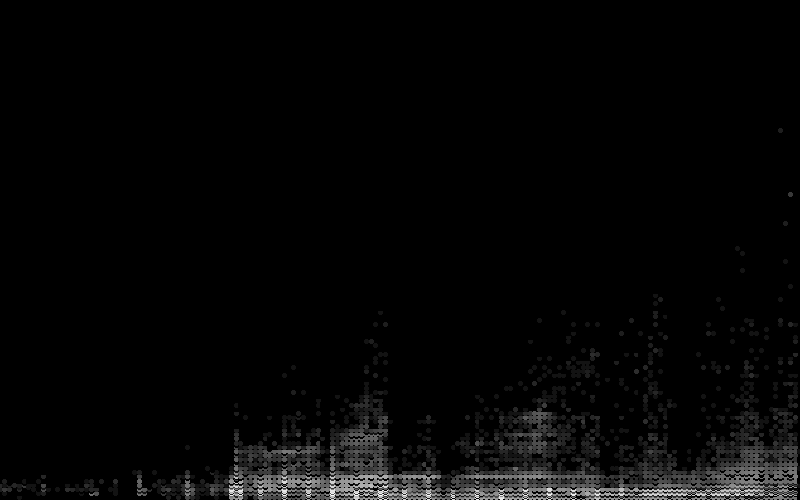

In [42]:
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That’s technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions. Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

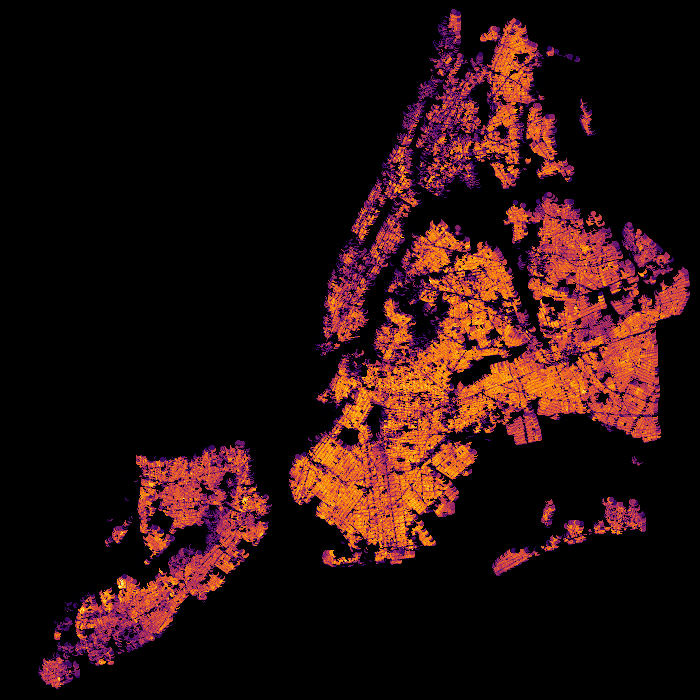

In [43]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we’re looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes. Unfortunately, Datashader doesn’t have the best documentation. Browse through the examples from their github repo. I would focus on the visualization pipeline and the US Census Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

Question  
You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you’ve discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.

In [44]:
#Create a subset of ny dataset by including AssessTot, AssessLand, lon and lat
ny_ast = ny[['AssessTot', 'AssessLand','lon','lat']].copy()

#Add AssesBldb column to ny_ast
ny_ast['AssessBldg'] = ny_ast['AssessTot'].sub(ny_ast['AssessLand'], axis=0)

#Labels 3 classes for each variable
labels = [['A', 'B', 'C'], ['1', '2', '3']]

#Set the breakpoints
p = 100 / len(labels[0]) 
q = np.percentile(ny_ast[['AssessLand', 'AssessBldg']], [p, 100 - p], axis=0) 

#Classify the building assessment and the the land
ny_ast['Class1'] = pd.cut(ny_ast['AssessLand'], [0, q[0][0], q[1][0], np.inf], right=False, labels=labels[0]) # bin
ny_ast['Class2'] = pd.cut(ny_ast['AssessBldg'], [0, q[0][1], q[1][1], np.inf], right=False, labels=labels[1]) # bin
ny_ast['Bldg_Class'] = ny_ast['Class1'].astype(str) + ny_ast['Class2'].astype(str)
ny_ast['Bldg_Class'] = pd.Categorical(ny_ast['Bldg_Class'])

#Print a simple of the new dataframe
ny_ast.head()


AssessTot  AssessLand        lon        lat  AssessBldg Class1 Class2  \
1    10156950      834300 -73.987066  40.704619     9322650      C      3   
17     351000      129600 -73.989310  40.704109      221400      C      3   
20     236700      178200 -73.990608  40.704581       58500      C      3   
22    7785450      514350 -73.988008  40.704131     7271100      C      3   
23   40980600      972000 -73.987077  40.704101    40008600      C      3   

   Bldg_Class  
1          C3  
17         C3  
20         C3  
22         C3  
23         C3

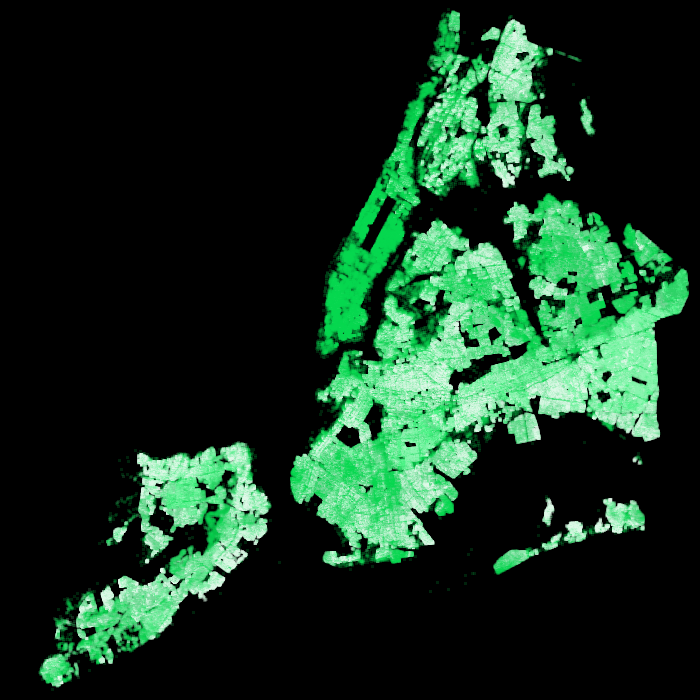

In [47]:
#Graphical representation of the assessment
colors = {'A1': '#e1faea', 'A2': '#cbf5da', 'A3': '#aafac6', 
          'B1': '#8bf7b1', 'B2': '#79d99b', 'B3': '#60e08d', 
          'C1': '#4cf587', 'C2': '#2fd468', 'C3': '#07d950'}
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny_ast, 'lon', 'lat', ds.count_cat('Bldg_Class'))
view = tf.shade(agg, color_key = colors)
export(tf.spread(view, px=1), 'cloropleth')

References  
https://plot.ly/python/filled-area-plots/
https://plot.ly/python/text-and-annotations/
https://anaconda.org/jbednar/legends/notebook
https://mkaz.tech/code/python-string-format-cookbook/
https://plot.ly/javascript/hover-text-and-formatting/
https://rpubs.com/josezuniga/359867
https://plot.ly/python/axes/
https://plot.ly/python/offline/
https://plot.ly/ggplot2/geom_bar/